## Notes
* **check model performance**
    * look into model performance for: NAN, SAO, BOT, MAR
    * check at what time of the year and in which cities biggest errors occur
* **modelling ideas**
    * use cross-validation
    * try fitting polynomial or using SVM instead of linear function
    * look into interpretability of random forest models
        * random forests often perform a lot better than linear regression
* **use HYY, KPZ, NAN, and MLP for testing new models**
    * NAN (high pollution) and KPZ (medium pollution) are very small datasets
    * MLP is a moderately small dataset and has high pollution
    * HYY is the biggest dataset and has low pollution
* **when using all datasets not all cities contribute the same amount of data points**
    * currently datapoints are shuffled and split 75% - 25%
    * test making differently sized datasets equally valuable
    * leave a few (3? - one for each pollution type) datasets out for testing
* **variables**
    * lat & lon are probably biased since there are so many datapoints in europe
    * season seems to only improve the model a little bit when splitting co and t up into trend and residual
    * training exp(t_trend, t_res) separately using log(N100)
    * experiment with window size for trend calculations: 30 seems to work well
* **other notes**
    * when merging with master branch remove code that swaps ABZ coordinates and remember that new dataset contains other variables
    * check with arto about video and final product
* **evaluating models in the report**
    * use p-values, rmse, rmse-e, and r2
    * lots of figure
    * include log-log plots of observed vs. predicted n100 concentrations
    * use log scale for evaluations
    * look at biases in model predictions

## Importing Libraries

In [1]:
import os
import yaml

import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Point

from scipy.signal import find_peaks, argrelmin
from scipy.stats import pearsonr, zscore

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Initiating directories and loading city data

In [2]:
# root directory path
ROOT_DIR = os.getcwd() + '/../'

# opening the configuration file
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

# directory path
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'

# reading in data about the cities
cities = pd.read_csv(ROOT_DIR + config['cities'])

# correcting the coordinates of Annaberg-Buchholz, Germany (city abbreviation: ABZ)
# latitude and longitude were swapped
abz_lat = cities.latitude[1]
cities.at[1, 'latitude'] = cities.longitude.loc[1]
cities.at[1, 'longitude'] = abz_lat

## Saving and mapping city related information

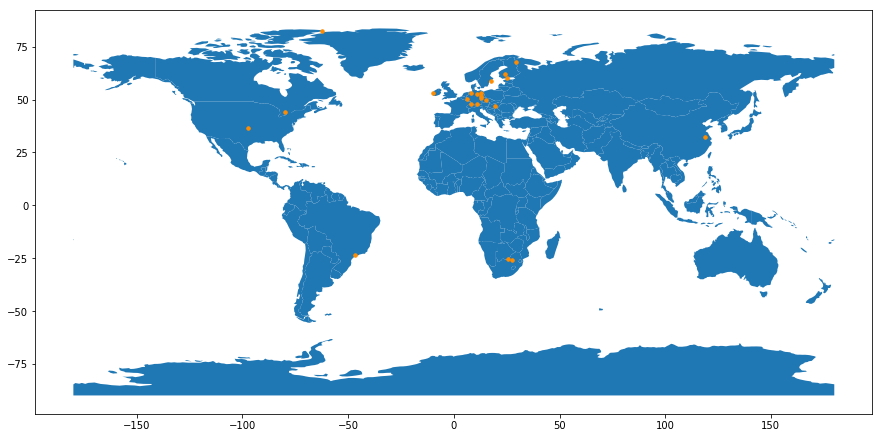

In [3]:
# saving the unique city abbrevations
unique_cities = cities.city.unique()

# dictionary mapping city abbrevations to full city names
city_names = {'ALE': 'Alert, Canada', 
              'ABZ': 'Annaberg-Buchholz, Germany', 
              'ASP': 'Aspvreten, Sweden', 
              'BOT': 'Botsalano, South Africa',   
              'BSL': 'Bösel (Südoldenburg), Germany',
              'EGB': 'Egbert, Canada',
              'HEL': 'Helsinki, Finland',
              'HPB': 'Hohenpeissenberg, Germany',
              'HYY': 'Hyytiälä, Finland',
              'KCE': 'Kosetice, Czech Republic',
              'KPZ': 'K-Puszta, Hungary',
              'MHD': 'Mace Head, Ireland',
              'MAR': 'Marikana, South Africa',
              'MLP': 'Melpitz, Germany',
              'NAN': 'Nanjing, China',
              'NEU': 'Neuglobsow, Germany',
              'SAO': 'São Paulo, Brazil',
              'SCH': 'Schauinsland, Germany',
              'SGP': 'Southern Great Plains, Oklahoma, USA',
              'VIE': 'Vielsalm, Belgium',
              'VAR': 'Värriö, Finland',
              'WAL': 'Waldhof, Germany'}

# creating a geodataframe with all cities
geometry = [Point(xy) for xy in zip(cities.longitude, cities.latitude)]
gdf = gpd.GeoDataFrame(cities.city, crs={'init': 'epsg:4326'}, geometry=geometry)

# geodataframe containing outlines of all countries in the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plotting the countries and cities
ax = world.plot(figsize=(15,10))
gdf.plot(ax=ax, color='darkorange', markersize=12);

## Setup for model parameters

In [4]:
# dictionary mapping predictors to their name to be used in printing
variable_dict = {'t':          'exp(0.04758*trend(T) + 0.05*residual(T) - 7.049)',
                 't_trend':    'trend(T)', 
                 't_res':      'residual(T)',
                 'co':         'log(CO)',
                 'co_trend':   'log(trend(CO))',
                 'co_res':     'residual(CO)',
                 'season_sin': 'sin(Season)',
                 'season_cos': 'cos(Season)',
                 'lat':        'scaled(Latitude)',
                 'lon':        'scaled(Longitude)'}


# function for selecting which variables to use in the models
def select_predictors():
    predictors = []
    
    if use_residual:
        predictors.append('n100_trend')
    if use_t:
        predictors.append('t')
        if use_residual:
            predictors.extend(['t_trend', 't_res'])
    if use_co:
        predictors.append('co')
        if use_residual:
            predictors.extend(['co_trend', 'co_res'])
    if use_season:
        predictors.extend(['season_sin', 'season_cos'])    
    if use_lat_lon and use_all_cities:
        predictors.extend(['lat', 'lon'])
    
    return predictors

## Calculating model variables 

In [5]:
# function for adding seaon_sin and season_cos columns to the dataframe
def add_seasons(data, no_seasons):
    # stripping the index containing the dates from the dataframe
    dates = data.index.tolist()
    
    # calculating the season as an integer between 0 and no_seasons
    season = [datetime.datetime.strptime(dates[i], "%Y-%m-%d").date() for i in range(len(dates))]
    season = np.array([season[i].timetuple().tm_yday for i in range(len(season))])
    season = np.round(season/(365/no_seasons))

    # adding the sin and cos of the season to the dataframe
    data['season_sin'] = np.sin(2*np.pi*season/len(np.unique(season)))
    data['season_cos'] = np.cos(2*np.pi*season/len(np.unique(season)))
    
    # mirroring season variables for cities in the southern hemisphere
    if use_all_cities:
        data.loc[data.lat < 0, ['season_sin', 'season_cos']] *= -1
        
    # setting all values that are equal to 0 to 0.000001 to avoid infinities
    data[['season_sin', 'season_cos']] = data[['season_sin', 'season_cos']].replace(0, 0.000001)
    
    return data, dates, season


# function for adding the trend and residual of n100, t, and co
def calc_trend_resid(data, non_numeric, window_size):
    ma_vars = ['n100']
    if use_t:
        ma_vars.append('t')
    if use_co: 
        ma_vars.append('co')
    
    data_ma = data.copy()
    data_ma = data_ma[ma_vars].rolling(window_size).mean()
    data_ma = pd.concat([data_ma, data[non_numeric]], axis=1)
    
    # residuals
    for ma_var in ma_vars[1:]:
        data[ma_var+'_res'] = data[ma_var] - data_ma[ma_var]
    
    # trends
    for ma_var in ma_vars:
        data[ma_var+'_trend'] = data_ma[ma_var]
    
    return data[window_size:]


def add_trend_resid(data, non_numeric, window_size):
    if use_all_cities:
        # creating a unique id for every row
        data_cities = []
        
        # iterating over all cities
        for city in unique_cities:
            subset = data.loc[data.city == city].copy()           
            subset = calc_trend_resid(subset, non_numeric, window_size)
            
            data_cities.append(subset)
        
        # joining the data from each city with the original dataframe and removing the unique ids
        return pd.concat(data_cities)
    else:
        return calc_trend_resid(data, non_numeric, window_size)

## Creating the dataset

In [6]:
def create_data(no_seasons, window_size):
    data = None
    dates = None
    season = None
    
    # lists for keeping track of column types
    numeric = ['n100'] + predictors
    non_numeric =[]
    
    # reading in the data
    if use_all_cities or city_name not in unique_cities:
        print('Selected cities:\n', unique_cities, '\n')
        data = pd.read_csv(DATA_DIR + 'all_merged.csv', index_col='date')
        data.columns = ['n100', 't', 'co', 'city', 'lat', 'lon']
        non_numeric += ['city']
    else:
        print('Selected city:', city_name, '\n') 
        data = pd.read_csv(DATA_DIR + city_name + '.csv', index_col='date')
        data.columns = ['n100', 't', 'co']
            
    # calculating seasons
    if use_season:
        data, dates, season = add_seasons(data, no_seasons)
            
    # split into trend and residual
    if use_residual:
        data = add_trend_resid(data, non_numeric, window_size)
    
    # removing outliers
    if rem_outliers:
        outliers = (np.abs(zscore(data[numeric])) < 3).all(axis=1)
        data = data[outliers]
        
    # reordering columns
    data = data[numeric + non_numeric]

    # dropping the index of the dataframe
    dates = data.index.tolist()
    data = data.reset_index(drop=True)

    return data, dates, season, numeric, non_numeric

## Transforming the dataset

In [7]:
def transform_data(data, dates):
    data_comb = []
    
    # n100 concentration
    if trans_n100:
        data_comb.append(data.n100.transform(np.log))  # log-transformed
        data_comb.append(data.n100_trend.transform(np.log))  # log-transformed trend
    else:
        data_comb.append(data.n100)
        data_comb.append(data.n100_trend)  # trend
    
    # temperature trend
    if use_t:
        data_comb.append(np.exp(0.04758*data.t_trend + 0.05*data.t_res - 7.049))  # pre-calculated transformation
        if use_residual:
            data_comb.append(data.t_trend)  # trend
            data_comb.append(data.t_res)  # residual
    
    # carbon monoxide
    if use_co:
        data_comb.append(data.co.transform(np.log))  # log-transformed
        if use_residual:
            data_comb.append(data.co_trend.transform(np.log))  # log-transformed trend
            data_comb.append(data.co_res)  # residual
    
    # seasons
    if use_season:
        data_comb.extend([data.season_sin, data.season_cos])
        
    # location
    if use_lat_lon and use_all_cities:
        data_comb.extend([data.lat/90, data.lon/180])  # scaled to [-1, 1]
    
    # city abbreviation
    if use_all_cities:
        data_comb.append(data.city)
    
    # creating a dataframe from the transformed columns
    data_comb = pd.DataFrame(np.array(data_comb).T)
    data_comb.columns = data.columns.values
    data_comb[numeric] = data_comb[numeric].astype('float64')
    
    # removing infinities
    subset_mask = np.isinf(data_comb[numeric]).any(axis=1) == False
    
    data = data.loc[subset_mask].reset_index(drop=True)
    data_comb = data_comb.loc[subset_mask].reset_index(drop=True)
    dates = pd.Series(dates).loc[subset_mask].reset_index(drop=True)
    
    print('Number of data points:', data_comb.shape[0], '\n')
    return data_comb, dates

## Preparing the data for model training

In [8]:
def split_data(data, data_comb, dates):
    # splitting the dataset into traning (75%) and testing (25%) sets
    indices = np.arange(len(data_comb))
    np.random.seed(42)
    np.random.shuffle(indices)
    split = int(len(indices) * 0.75)
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    # predictor variables
    X_train = np.take(data_comb[predictors], train_indices, 0)
    X_test = np.take(data_comb[predictors], test_indices, 0)
    
    # n100 concentration
    y_train = np.take(data_comb.n100, train_indices, 0)
    y_test = np.take(data.n100, test_indices, 0)
    log_y_test = np.take(data_comb.n100, test_indices, 0)

    # dates
    dates_test = np.take(dates, test_indices, 0)

    print('Train set shapes:', X_train.shape, 'and', y_train.shape)
    print('Test set shapes:', X_test.shape, 'and', y_test.shape, '\n')        
    return y_train, y_test, log_y_test, X_train, X_test, dates_test

## Helper functions

In [9]:
# function for getting a string of the counded correlation coefficient
    def get_corr(a, b, pr=3):
        corr = pearsonr(a, b)[0]
        corr = np.round(corr, pr)
        return str(corr)

## Functions for exploratory data visualizations

In [10]:
# function for plotting N100, T, and CO data distributions
def plot_distributions(data, data_comb, bins=100):
    histtype = 'stepfilled'

    fig, ax = plt.subplots(2, 3)
    fig.set_size_inches(15,10)

    i = 0
    for col in ['n100', 't', 'co']:
        ax[0, i].hist(np.array(data[col]), bins=bins, histtype=histtype)
        hist = np.histogram(np.array(data_comb[col]), bins=bins)
        width = hist[1][1:] - hist[1][:-1]
        ax[1, i].bar(hist[1][:-1] + (width/2), hist[0], width=width)
        i += 1

    ax[0, 2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    ax[0, 0].set_title('N100 Concentration')
    ax[0, 1].set_title('Temperature')
    ax[0, 2].set_title('Carbon Monoxide')

    if trans_n100:
        ax[1, 0].set_title('N100 Concentration (log-transformed)')
    else:
        ax[1, 0].set_title('N100 Concentration')
        
    ax[1, 1].set_title('Temperature (transformed)')
    ax[1, 2].set_title('Carbon Monoxide (log-transformed)')


# function for plotting the N100, T, and CO data and trend for one city
def plot_trends(data, dates):
    idx = data.shape[0]
    step = int(idx / 10)
    xticks_mask = list(range(0, idx, step))
    xticks = pd.Series(dates).iloc[xticks_mask]

    fig, ax = plt.subplots(5, 1)
    fig.set_size_inches(15,25)
    
    ax[0].plot(data.n100, label='N100 Concentration')
    ax[0].plot(data.n100_trend, label='Trend')

    ax[1].plot(data.t, label='Temperature', c='green')
    ax[1].plot(data.t_trend, label='Trend', c='red')

    ax[2].plot(data.co, label='Carbon Monoxide', c='purple')
    ax[2].plot(data.co_trend, label='Trend', c='yellow')
    
    ax[3].plot(data.t_res, label='Temperature Residual', c='green')
    ax[4].plot(data.co_res, label='Carbon Monoxide Residual', c='purple')

    for i in range(5):
        ax[i].legend()
        ax[i].set_xticks(xticks_mask)
        ax[i].set_xticklabels(xticks)

    fig.tight_layout(pad=6)
    fig.suptitle('Input Data, Trends, and Residuals for '+city_name)


# function for plotting the correlation between N100 concentration, T, and CO 
def plot_correlations(data):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    fig.suptitle('Correlations between N100 Concentration and Predictors for '+city_name)

    # plotting the data
    ax[0].scatter(data.t, data.n100, s=2, alpha=alpha)
    ax[1].scatter(data.co, data.n100, s=2, alpha=alpha)

    # labelling the axes
    ax[0].set_xlabel('Temperature')
    ax[1].set_xlabel('Carbon Monoxide')
    for i in range(2):
        ax[i].set_ylabel('N100 Concentration')

    # adding correlation coefficients
    pos = 0.75
    ax[0].text(pos, pos, 'p = ' + get_corr(data.t, data.n100), weight='bold', transform=ax[0].transAxes)
    ax[1].text(pos, pos, 'p = ' + get_corr(data.co, data.n100), weight = 'bold', transform=ax[1].transAxes)
    
    fig.tight_layout(pad=4)

## Functions for evaluating models

In [11]:
# function for printing the equation created by the linear regression model
def print_equation(model, sf=4):
    # obtaining the model parameter values with sf significant figures
    coefs = []
    for coef in model.coef_:
        coef = np.round(coef, sf-int(np.floor(np.log10(abs(coef))))-1)
        coefs.append(coef)
    
    coefs = np.array(coefs)
    intercept = np.round(model.intercept_, sf-int(np.floor(np.log10(abs(model.intercept_))))-1) 
    
    # string for the model equation
    equation = 'Model equation:\nlog(N100) =' if trans_n100 else 'Model equation:\nN100 ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + variable_dict[predictors[i]]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for calculating the R2 score and RMSE
def eval_model(predictions, model):
    r2 = r2_score(y_test, predictions)
    print('R2 score on test set:\n%.3f\n' % r2)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set:\n%.3f\n' % rmse)

    
# function for plotting the log-transformed observed and predicted n100 concentrations against each other
def log_log_eval(log_predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted Log-Transformed N100 Concentration')
    
    axis_min, axis_max = 0, 10
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(log_y_test, log_predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(log_y_test, log_predictions, s=2, alpha=alpha)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted log-transformed N100 concentration:\n'+
          get_corr(log_y_test, log_predictions)+'\n')

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration')
    
    axis_min, axis_max = 0, int(y_test.max())
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(y_test, predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(y_test, predictions, s=2, alpha=alpha)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted N100 concentration:\n'+get_corr(y_test, predictions)+'\n')


# function for plotting the predicted and observed n100 concentrations
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - ' + city_name + ' - Test Set')
    
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    
    xticks_mask = list(range(0, dates_test.shape[0], int(dates_test.shape[0] / 8)))
    xticks = dates_test.iloc[xticks_mask]
    plt.xticks(xticks_mask, xticks)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N100 concentration')
    
def plot_all_results(name, predictions, data):
    plt.figure(figsize=(15, 5))
    plt.title('Performance of ' + name + ' Model - ' + city_name + '- Whole Dataset')
    
    plt.plot(data.n100, label='Observed')
    plt.plot(predictions, label='Predicted', alpha=0.75)
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration')
    plt.legend()

    plt.figure(figsize=(15, 5))
    plt.title('Residual of Predictions for ' + name + ' Model - ' + city_name + '- Whole Dataset')
    
    plt.plot(np.abs(data.n100 - predictions), c='green', alpha=0.75)
    plt.hlines([0, 2500, 5000], 0, len(predictions), linestyles = 'dotted')
    plt.xlabel('Timestep')
    plt.ylabel('N100 Concentration')

## Creating the dataframes

In [12]:
city_name = 'HYY'        # abbreviation of city to use
no_seasons = 24          # number of "seasons" to use (number of parts to split the year into)
window_size = 30         # window size for calculating trend 

use_all_cities = True    # use data from all cities?
use_t = True             # use temperature data?
use_co = True            # use carbon monoxide data?
use_season = True        # use season data?
use_lat_lon = False      # latitude and longitude data?
use_residual = True      # calculate the trend (rolling mean) and residual of t and co?

trans_n100 = False       # log-transform N100 concentration?
rem_outliers = False     # remove outliers?

# selecting predicting variables
predictors = select_predictors()

# creating a dataframe of the original data
df, dates, season, numeric, non_numeric = create_data(no_seasons, window_size)

# creating a dataframe of the transformed data
df_comb, dates = transform_data(df, dates)

# updating city_name for plotting
if use_all_cities:
    city_name = 'All Cities'
    
# alpha parameter for scatter plots
alpha = np.round((45000 + np.invert(df_comb.shape[0]))/45000, 3)

# removing unneccessary predictors
if use_residual:
    predictors.remove('n100_trend')
    predictors.remove('t_trend')
    predictors.remove('t_res')
#     predictors.remove('t')
    predictors.remove('co')

print('Using predictors:', predictors)

# printing the head of the transformed dataset
df_comb.head()

Selected cities:
 ['ALE' 'ABZ' 'ASP' 'BOT' 'BSL' 'EGB' 'HEL' 'HPB' 'HYY' 'KCE' 'KPZ' 'MHD'
 'MAR' 'MLP' 'NAN' 'NEU' 'SAO' 'SCH' 'SGP' 'VIE' 'VAR' 'WAL'] 

Number of data points: 41852 

Using predictors: ['t', 'co_trend', 'co_res', 'season_sin', 'season_cos']


,n100,n100_trend,t,t_trend,t_res,co,co_trend,co_res,season_sin,season_cos,city
0,71.424271,54.670865,73.352367,241.789765,-3.201645,-15.959415,-15.952202,-8.483858e-10,0.481754,0.876307,ALE
1,57.286471,53.311555,84.130019,241.642169,-0.319419,-15.974355,-15.956617,-2.066297e-09,0.481754,0.876307,ALE
2,50.475244,51.761553,88.295408,241.554299,0.730691,-15.978772,-15.960797,-2.085000e-09,0.481754,0.876307,ALE
3,53.682375,50.673285,81.665458,241.416064,-0.698904,-15.961700,-15.965078,3.942792e-10,0.481754,0.876307,ALE
4,65.742391,51.229296,75.255677,241.215352,-2.142702,-15.952522,-15.967083,1.705803e-09,0.481754,0.876307,ALE


## Exploratory Data Analysis

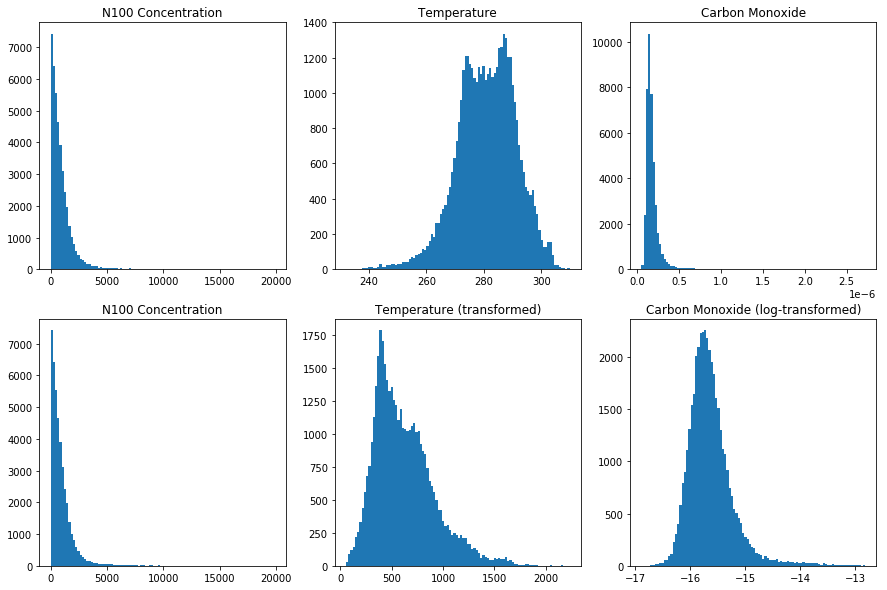

In [13]:
# value distributions of N100, temperature, and carbon monoxide before and after transformation
if use_t and use_co:
    plot_distributions(df, df_comb)

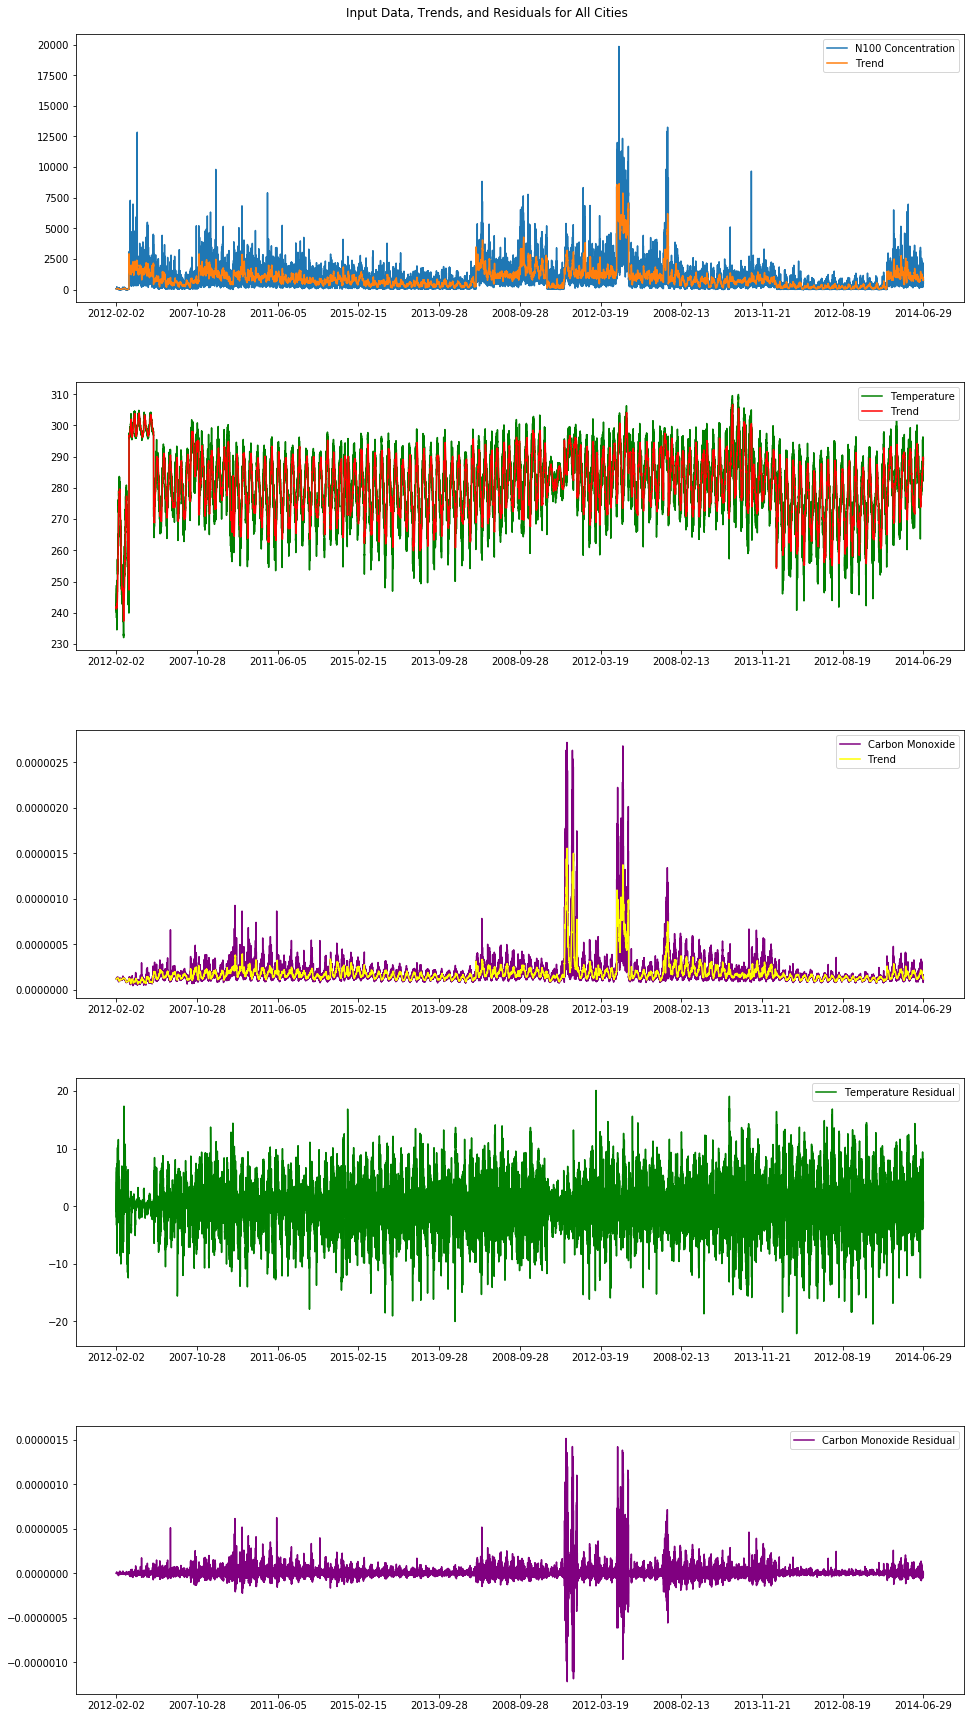

In [14]:
# plotting the transformed data, trends, and residuals
if use_t and use_co:
    plot_trends(df, dates)

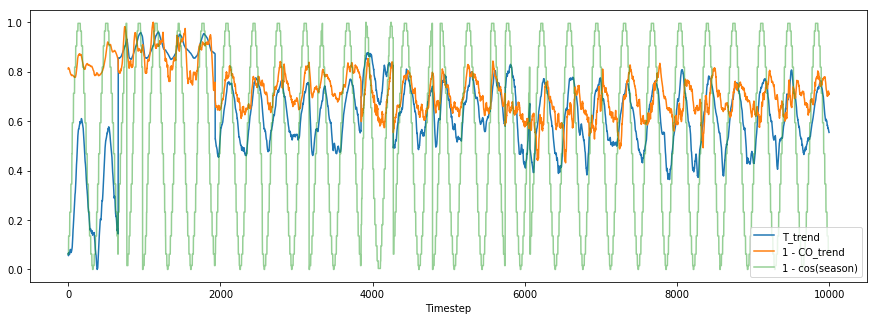

In [16]:
# relationship between min-max-scaled temperature trend, carbon monoxide trend, and season
if use_t and use_co and use_season:
    t = preprocessing.minmax_scale(np.array(df_comb.t_trend).reshape(-1, 1))
    co = 1-preprocessing.minmax_scale(np.array(df_comb.co_trend).reshape(-1, 1))
    sea = 1-preprocessing.minmax_scale(np.array(df_comb.season_cos).reshape(-1, 1))

    view_size = min(len(t), 10000)
    fig = plt.figure(figsize=(15,5))
    
    plt.plot(t[:view_size], label='T_trend')
    plt.plot(co[:view_size], label='1 - CO_trend')
    plt.plot(sea[:view_size], label='1 - cos(season)', alpha=0.5)

    plt.xlabel('Timestep')
    plt.legend();

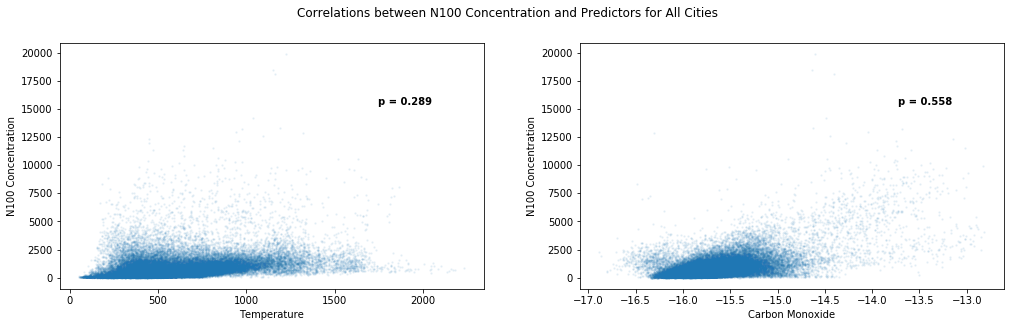

In [17]:
# correlations between N100, temperature, and carbon monoxide
if use_t and use_co:
    plot_correlations(df_comb)

In [18]:
# autocorrelation for temperature and carbon monoxide
print('Autocorrelation of')
print()
print('Temperature Trend: {:0.3f}'.format(df.t_trend.autocorr(lag=window_size)))
print('Temperature Residual: {:0.3f}'.format(df.t_res.autocorr(lag=window_size)))
print()
print('Carbon Monoxide Trend: {:0.3f}'.format(df.co_trend.autocorr(lag=window_size)))
print('Carbon Monoxide Residual: {:0.3f}'.format(df.co_res.autocorr(lag=window_size)))

Autocorrelation of

Temperature Trend: 0.850
Temperature Residual: 0.094

Carbon Monoxide Trend: 0.859
Carbon Monoxide Residual: -0.025


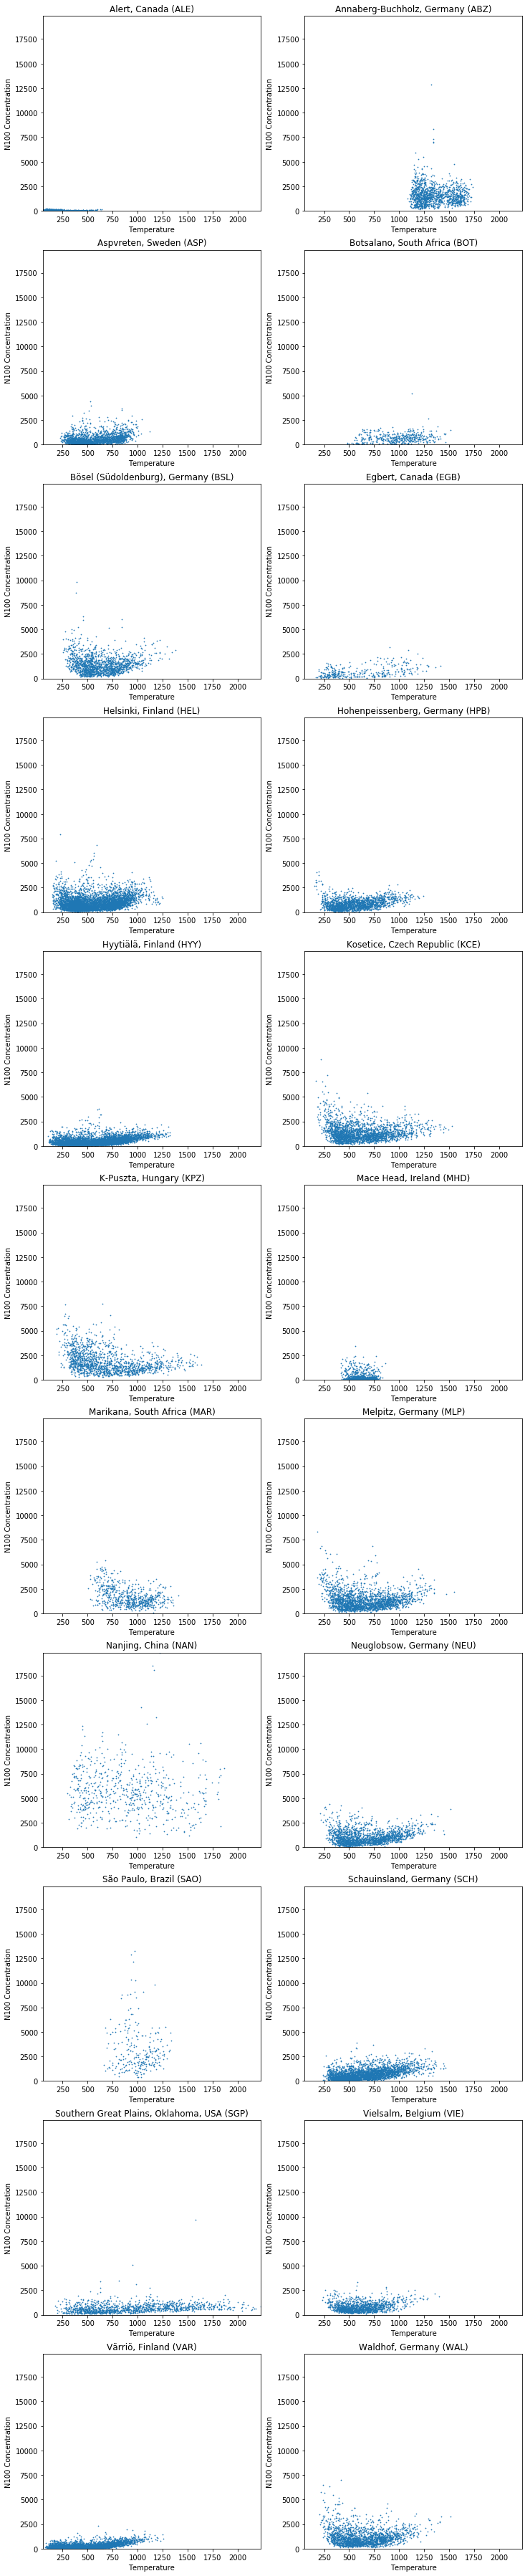

In [19]:
# distribution of n100 vs. temperature for individual cities
if use_all_cities:
    fig, ax = plt.subplots(11, 2)
    fig.set_size_inches(12,65)

    i, j = 0, 0

    for city in unique_cities:
        subset = df_comb[df_comb.city == city]    
        ax[i, j].scatter(subset.t, subset.n100, s=0.5)
    #     ax[i, j].hist(subset.t, bins=80)
    #     ax[i, j].vlines(temp_split, 0, ax[i, j].get_ylim()[1], color='orange')

        ax[i, j].set_title(city_names[city]+' ('+city+')')
        ax[i, j].set_xlim(df_comb.t.min(), df_comb.t.max())
        ax[i, j].set_ylim(df_comb.n100.min(), df_comb.n100.max())
        ax[i, j].set_xlabel('Temperature')
        ax[i, j].set_ylabel('N100 Concentration')

        if j == 1:
            i += 1
            j = 0
        else:
            j = 1

In [20]:
# correlation between model variables
print('Correlations between model variables:\n')

a = 'n100'
for b in predictors:
    corr = get_corr(df_comb[a], df_comb[b])
    print(a, '&', b, corr) 

# for a in predictors:
#     print()
#     for b in predictors:
#         if a != b:
#             corr = get_corr(df_comb[a], df_comb[b])
#             print(a, '&', b, corr)

Correlations between model variables:

n100 & t 0.289
n100 & co_trend 0.488
n100 & co_res 0.21
n100 & season_sin 0.055
n100 & season_cos -0.015


## Modelling

In [13]:
y_train, y_test, log_y_test, X_train, X_test, dates_test = split_data(df, df_comb, dates)

Train set shapes: (31389, 5) and (31389,)
Test set shapes: (10463, 5) and (10463,) 



### Linear Regression

Model equation:
N100 = 1.382*exp(0.04758*trend(T) + 0.05*residual(T) - 7.049) + 1496.0*log(trend(CO)) + 2802000000.0*residual(CO) - 28.39*sin(Season) + 59.87*cos(Season) + 23420.0

Correlation between observed and predicted N100 concentration:
0.658

R2 score on test set:
0.433

RMSE on test set:
757.894



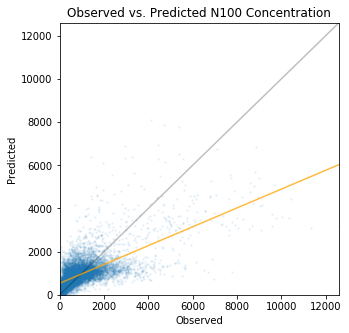

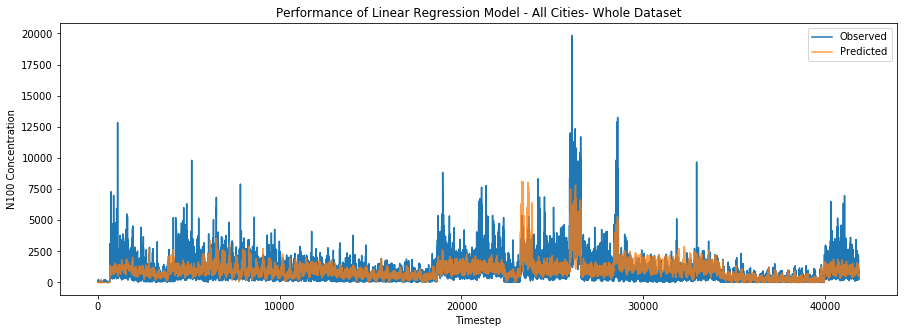

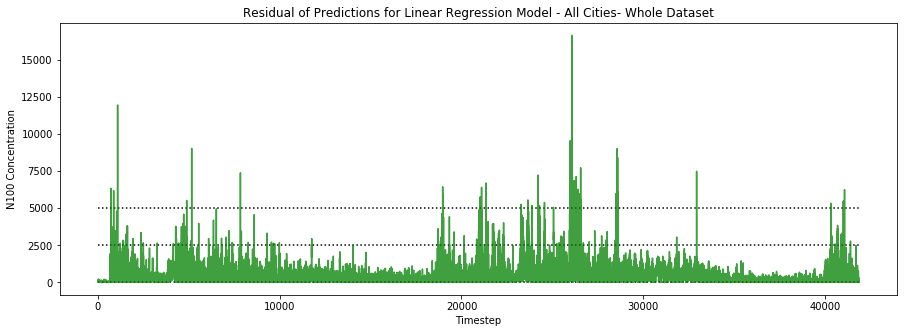

In [14]:
# fitting the linear regression model
model = LinearRegression().fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)

# removing predictions that are negative
predictions[predictions < 0] = 0

# printing the model evaluation
print_equation(model)

# checking if the n100 data was log-transformed
if trans_n100:
    # plotting log(observed) vs. log(predicted) n100 concentrations
    log_log_eval(predictions)
    
    # reverse transforming the data if neccessary
    predictions = np.exp(predictions)
    
# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)

# evaluating the model performance
eval_model(predictions, model)

# making predictions for the whole dataset
predictions = model.predict(np.array(df_comb[predictors]))
predictions[predictions < 0] = 0
predictions = np.exp(predictions) if trans_n100 else predictions
        
# plotting the observed and predicted n100 concentrations against time
plot_all_results('Linear Regression', predictions, df)

### Random Forest Regression

Correlation between observed and predicted N100 concentration:
0.725

R2 score on test set:
0.506

RMSE on test set:
707.198



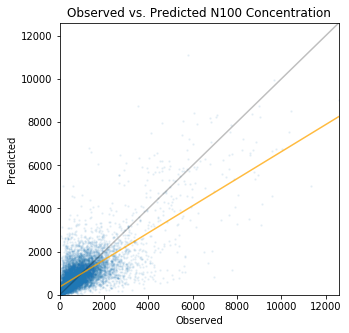

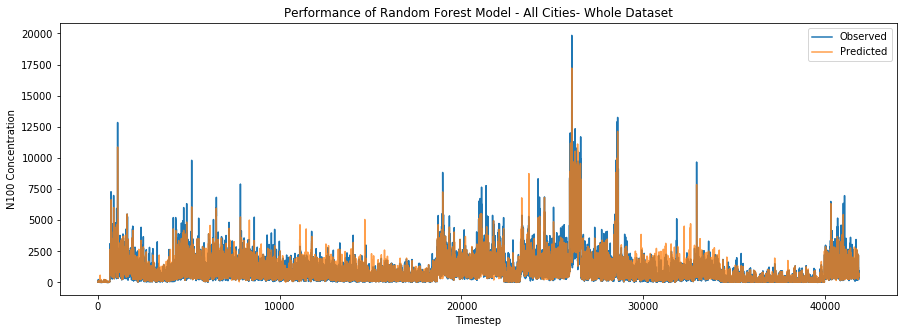

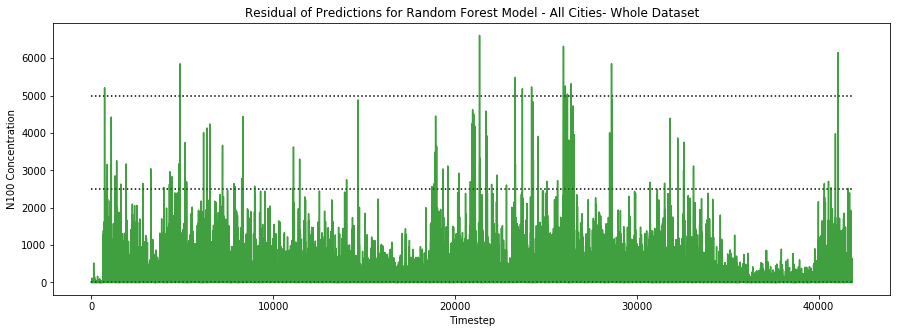

In [23]:
# fitting the random forest model
model = RandomForestRegressor(n_estimators=len(predictors)).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)

# removing predictions that are negative
predictions[predictions < 0] = 0

# checking if the n100 data was log-transformed
if trans_n100:
    # plotting log(observed) vs. log(predicted) n100 concentrations
    log_log_eval(predictions)
    
    # reverse transforming the data if neccessary
    predictions = np.exp(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions)

# evaluating the model performance
eval_model(predictions, model)

# making predictions for the whole dataset
predictions = model.predict(np.array(df_comb[predictors]))
predictions[predictions < 0] = 0
predictions = np.exp(predictions) if trans_n100 else predictions
        
# plotting the observed and predicted n100 concentrations against time
plot_all_results('Random Forest', predictions, df)